In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [44]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [45]:
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
import keras

In [46]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, Concatenate, Dropout, BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model, load_model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.callbacks import LearningRateScheduler
from keras.utils.vis_utils import plot_model

In [47]:
filename = "/content/drive/MyDrive/ImageCaptioning/Flickr8k_text/Flickr8k.token.txt" # Absolute path of the caption 
file = open(filename,'r')
doc = file.read() # This will contain the Caption of the each image in a textual format
print(doc[:400])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wood


In [48]:
# Loading the Caption with the Image name as a id to the dictionary : dict[image_name] = captions

descriptions =dict()
for line in doc.split('\n'):# splitting the doc using newline

  if len(line)<2:
    continue
  tokens =  line.split() #splitting the line by white spaces

  image_id , image_desc = tokens[0],tokens[1:]
  image_desc = ' '.join(image_desc) # joining the generated words by splitting into again captions

  # image id -> 1000268201_693b08cb0e.jpg#0 we have to split it by dot to get unique name of image
  image_name = image_id.split('.')[0]

  if image_name not in descriptions.keys():
    descriptions[image_name] = list()
  
  descriptions[image_name].append(image_desc)

print(len(descriptions))

8092


In [49]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [50]:
table = str.maketrans('','',string.punctuation)

for _, captions in descriptions.items():
  for i in range(len(captions)):

    desc = captions[i].split()

    # removing punctuations
    desc = [c.translate(table) for c in desc]

    # removing non alphabetic characters
    desc = [word for word in desc if word.isalpha()]

    # removing single length words
    desc = [word for word in desc if len(word)>=2]

    # converting all the char into lower 
    desc = [word.lower() for word in desc]

    captions[i] = ' '.join(desc)

In [51]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [52]:
vocabulary = set()

for key in descriptions:
  for d in descriptions[key]:
    vocabulary.update(d.split())

print('Vocabulary Size :',len(vocabulary))

Vocabulary Size : 8763


In [53]:
filename1 = "/content/drive/MyDrive/ImageCaptioning/Flickr8k_text/Flickr_8k.trainImages.txt" # Captions for training dataset
file = open(filename1,'r')
train_doc = file.read()

training_image_name = list()

for line in train_doc.split('\n'):
  if len(line)<1:
    continue
  
  id = line.split('.')[0]
  training_image_name.append(id)

filename2 = "/content/drive/MyDrive/ImageCaptioning/Flickr8k_text/Flickr_8k.devImages.txt" # Captions for training dataset
file = open(filename2,'r')
val_doc = file.read()

for line in val_doc.split('\n'):
  if len(line)<1:
    continue
  
  id = line.split('.')[0]
  training_image_name.append(id)


training_image_name = set(training_image_name)
print('Length of Train Datset:',len(training_image_name))
print(training_image_name)

Length of Train Datset: 7000
{'3530504007_3272c57e21', '1807169176_7f5226bf5a', '609681901_66809d2dc1', '2017276266_566656c59d', '382701159_f98c1988cd', '118309463_a532b75be9', '3582689770_e57ab56671', '3197891333_b1b0fd1702', '3372251830_baa3665928', '3447155358_5b5b59b15e', '1299459562_ed0e064aee', '613030608_4355e007c7', '483841513_e660391880', '3647446816_bd4383c828', '3579842996_3a62ec1bc7', '162743064_bb242faa31', '3268191118_ba25fabab6', '3582465732_78f77f34ae', '3627216820_4952bacbcb', '3721799573_2f470950e0', '536537638_f5ee42410b', '566794036_60f7acdf35', '157139628_5dc483e2e4', '2479180530_7ebba2d8bf', '2848895544_6d06210e9d', '3489774350_a94e6c7bfc', '3203878596_cbb307ce3b', '3475552729_a3abd81ee6', '2567812221_30fb64f5e9', '2734669176_c272b42597', '2974587819_742fb7c338', '934375844_dd149fed18', '3393152604_27bd1037f2', '3628059004_5c3529b120', '2504991916_dc61e59e49', '3354200211_35348e47d8', '3478877323_0a507a601b', '3391924827_53b31542ce', '3032790880_d216197d55', '3356

In [22]:
images = '/content/drive/MyDrive/ImageCaptioning/Flicker8k_Dataset/'
img = glob.glob(images+'*.jpg')

print(img[0])

/content/drive/MyDrive/ImageCaptioning/Flicker8k_Dataset/416960865_048fd3f294.jpg


In [54]:
training_image_file  = set(open(filename1, 'r').read().strip().split('\n')) # image_name.jpg

# Create a list of all the training images with their full path names
training_image_full_path = [] # /content/drive/MyDrive/ImageCaptioning/Flicker8k_Dataset/image_name.jpg

for i in img: # img is list of full path names of all images
    if i[len(images):] in training_image_file: # Check if the image belongs to training set
        training_image_full_path.append(i) # Add it to the list of train images

training_image_file2  = set(open(filename2, 'r').read().strip().split('\n')) # image_name.jpg
for i in img: # img is list of full path names of all images
    if i[len(images):] in training_image_file2: # Check if the image belongs to training set
        training_image_full_path.append(i) # Add it to the list of train images

In [55]:
print(len(training_image_full_path))
print(training_image_full_path[0])

7000
/content/drive/MyDrive/ImageCaptioning/Flicker8k_Dataset/416650559_cd08d3cd96.jpg


In [56]:
test_images_file = '/content/drive/MyDrive/ImageCaptioning/Flickr8k_text/Flickr_8k.testImages.txt'

test_image_file = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_image_full_path = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_image_file: # Check if the image belongs to test set
        test_image_full_path.append(i) # Add it to the list of test images

In [57]:
print(len(test_image_full_path))
print(test_image_full_path[0])

1000
/content/drive/MyDrive/ImageCaptioning/Flicker8k_Dataset/416960865_048fd3f294.jpg


In [58]:
train_desc = dict()

for i in descriptions.keys():
  if i in training_image_name:
    if i not in train_desc:
      train_desc[i] = list()

    for cap in descriptions[i]:
      desc = 'startseq '+cap+' endseq'
      train_desc[i].append(desc)

print(len(train_desc))

7000


In [59]:
train_desc['2254913901_569f568926']

['startseq louis vuitton store window at night endseq',
 'startseq woman looks at clothes in louis vuitton store window endseq',
 'startseq woman widow shops outside of louis vuitton store endseq',
 'startseq the woman in black is looking at outfits in clothing store window endseq',
 'startseq woman on the street window shops in front of the store louis vuitton endseq']

In [60]:
model = InceptionV3(weights='imagenet') # loading the inceptionv3 model
new_model = Model (model.input, model.layers[-2].output) # creating a new_model which have same input but second last layer as an output

In [61]:
def preprocess(path):
  img_ = load_img(path,target_size=(299,299)) # reshaping the input images into 299x299 same as inceptionv3
  x_arr = img_to_array(img_) # converting the image into 3d array
  x_arr = np.expand_dims(x_arr,axis=0) # adding a new dimension => (299,299,3) will converted into (1,299,299,3)
  x_arr = preprocess_input(x_arr)

  return x_arr                      

In [62]:
def encode(path):
    image = preprocess(path) # preprocess the image
    feat_vec = new_model.predict(image) # Get the encoding vector for the image
    feat_vec = np.reshape(feat_vec, feat_vec.shape[1]) # reshape from (1, 2048) to (2048, )

    return feat_vec

In [ ]:
# Run only once - to store the training image features
encoding_train_image = {}
i=1
for img_ in training_image_full_path:
    encoding_train_image[img_[len(images):]] = encode(img_)

In [ ]:
with open("/content/drive/MyDrive/ImageCaptioning/Resources/encoded_train_images_with_val.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train_image, encoded_pickle)

In [63]:
train_features = load(open("/content/drive/MyDrive/ImageCaptioning/Resources/encoded_train_images_with_val.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=7000


In [ ]:
# Run only once - to store the testing image features
encoding_test_image = {}
i=1
for img_ in test_image_full_path:
    encoding_test_image[img_[len(images):]] = encode(img_)

In [ ]:
with open("/content/drive/MyDrive/ImageCaptioning/Resources/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test_image, encoded_pickle)

In [64]:
test_features = load(open("/content/drive/MyDrive/ImageCaptioning/Resources/encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(test_features))

Photos: test=1000


In [65]:
all_train_captions = []
for key in train_desc.keys():
    for cap in train_desc[key]:
        all_train_captions.append(cap)
len(all_train_captions)

35000

In [66]:
str_all_train_captions = str(all_train_captions).replace(',',' ').replace('\'',' ')

In [67]:
# considering all those words which appear more than or equal to 2 times in our training corpus

word_count_threshold = 5
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab_ = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab_)))

preprocessed words 8169 -> 2764


In [68]:
vocab_[:5]

['startseq', 'child', 'in', 'pink', 'dress']

In [69]:
ixtoword = {} # will give word as an output for an index ( from 1 to 1889)
wordtoix = {} # will give an index as an output for a word

ix = 1
for w in vocab_:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [70]:
# Run only once 
with open("/content/drive/MyDrive/ImageCaptioning/Resources/indextoworddictt.pkl", "wb") as encoded_pickle:
    pickle.dump(ixtoword, encoded_pickle)

In [71]:
# Run only once
with open("/content/drive/MyDrive/ImageCaptioning/Resources/wordtoindexdictt.pkl", "wb") as encoded_pickle:
    pickle.dump(wordtoix, encoded_pickle)

In [72]:
vocab_size = len(ixtoword) + 1 # one for appended 0's after padding 
vocab_size

2765

In [73]:
all_desc = list()
for key in train_desc.keys():
  [all_desc.append(d) for d in train_desc[key]]

max_length = max(len(d.split()) for d in all_desc)
print(max_length)

34


In [74]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [75]:
from gensim.models import Word2Vec

all_sentences = nltk.sent_tokenize(str_all_train_captions)
all_words = [nltk.word_tokenize(sent) for sent in all_sentences]

w2v = Word2Vec(all_words)
print(w2v.wv['startseq'].shape)

(100,)


In [76]:
w2v_vocab = w2v.wv.vocab

In [77]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim)) # embedding vector of 100 len for every word in our training vocab

for word, ix in wordtoix.items():
  if str(word) in w2v_vocab:

    embedding_matrix[ix] = w2v.wv[str(word)]

print(embedding_matrix.shape)

(2765, 100)


In [78]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
      for key, desc_list in descriptions.items():
          n+=1
          # retrieve the photo feature
          photo = photos[key + '.jpg']
          for desc in desc_list:
              # encode the sequence
              seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
              # split one sequence into multiple X, y pairs
              for i in range(1, len(seq)):
                  # split into input and output pair
                  in_seq, out_seq = seq[:i], seq[i]
                  # pad input sequence
                  in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                  # encode output sequence
                  out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                  # store
                  X1.append(photo)
                  X2.append(in_seq)
                  y.append(out_seq)
          # yield the batch data
          if n==num_photos_per_batch:
              yield ([array(X1), array(X2)], array(y))
              X1, X2, y = list(), list(), list()
              n=0


In [79]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [80]:
def beam_search_predictions(image, beam_index):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

---
# **Naive Merge Model**

In [ ]:
def naiveModel(vocab_size,max_length,embedding_dim): 
  inputs1 = Input(shape=(2048,))
  fe1 = Dropout(0.25)(inputs1)
  fe2 = Dense(256, activation='relu')(fe1)
  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
  se2 = LSTM(256)(se1)
  se3 = Dropout(0.25)(se2)
  decoder1 = add([fe2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  outputs = Dense(vocab_size, activation='softmax')(decoder2)
  model = Model(inputs=[inputs1, inputs2], outputs=outputs)

  return model

In [ ]:
model = naiveModel(vocab_size,max_length,embedding_dim)
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

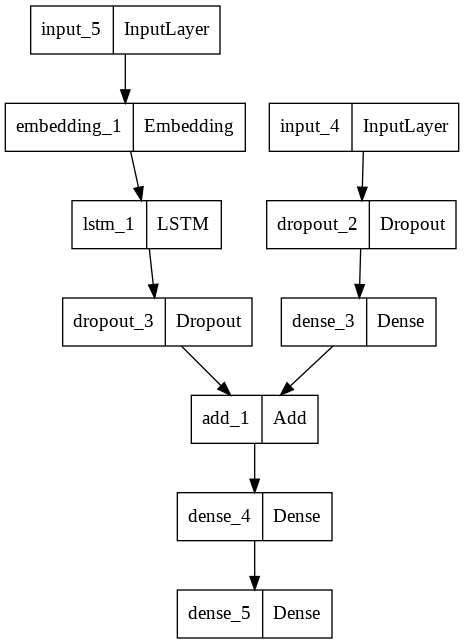

In [ ]:
plot_model(model)

---
**Training**

In [ ]:
epochs = 10
number_pics_per_batch = 6
steps = len(train_desc)//number_pics_per_batch

In [ ]:
#First part training
for i in range(epochs):
    generator = data_generator(train_desc, train_features, wordtoix, max_length, number_pics_per_batch)
    history1 = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

1166/1166 [==============================] - 124s 106ms/step - loss: 3.5504 - accuracy: 0.2494 - lr: 0.0010


In [ ]:
#Second part training

model.optimizer.lr = 0.0005
epochs = 10
number_pics_per_batch = 6
steps = len(train_desc)//number_pics_per_batch


for i in range(epochs):
    generator = data_generator(train_desc, train_features, wordtoix, max_length, number_pics_per_batch)
    history2 = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

1166/1166 [==============================] - 122s 104ms/step - loss: 3.2463 - accuracy: 0.2798 - lr: 5.0000e-04


In [ ]:
# Third part training

model.optimizer.lr = 0.00005
epochs = 5
number_pics_per_bath = 3
steps = len(train_desc)//number_pics_per_bath

for i in range(epochs):
    generator = data_generator(train_desc, train_features, wordtoix, max_length, number_pics_per_batch)
    history3 = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

2333/2333 [==============================] - 247s 106ms/step - loss: 3.2236 - accuracy: 0.2845 - lr: 5.0000e-05


In [ ]:
# Run only once 
model.save('/content/drive/MyDrive/ImageCaptioning/Model/encoder_decoder.h5')

In [86]:
model = load_model('/content/drive/MyDrive/ImageCaptioning/Model/encoder_decoder.h5')

**Testing**

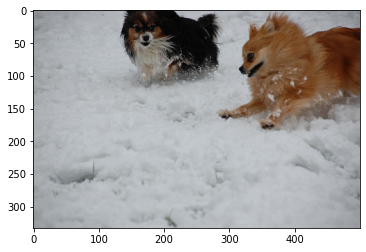

Greedy: dog is running through the snow
Beam: brown and white dog is running through the snow


In [ ]:
pic = '2398605966_1d0c9e6a20.jpg'
images_path = '/content/drive/MyDrive/ImageCaptioning/Flicker8k_Dataset/'

encoded_image = test_features[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(encoded_image))
print("Beam:",beam_search_predictions(encoded_image,7))

In [ ]:
test_images_file = '/content/drive/MyDrive/ImageCaptioning/Flickr8k_text/Flickr_8k.testImages.txt'
test_image_file = open(test_images_file, 'r').read().strip().split('\n')

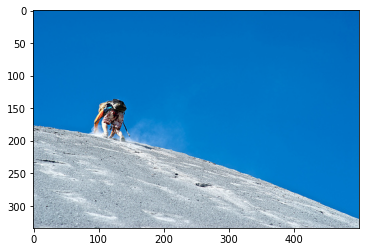

Greedy: man is standing on the snow of the snow
Beam: man stands on the edge of the snow





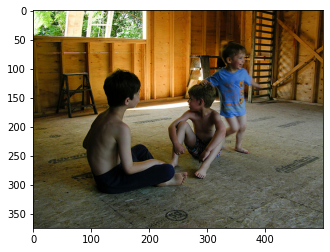

Greedy: two girls sit in the hay
Beam: two girls sit in the hay





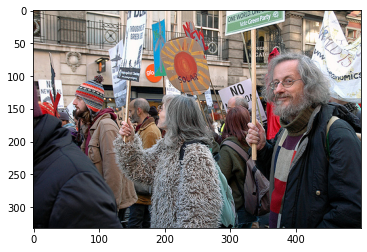

Greedy: man and woman are standing in busy
Beam: group of people wearing in front of crowd





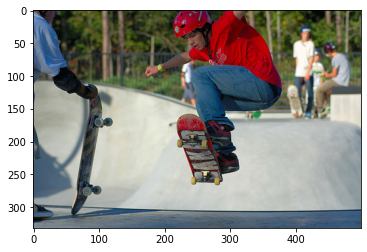

Greedy: boy boy in red jacket and khaki on the street
Beam: person boy in red jacket and khaki on the street





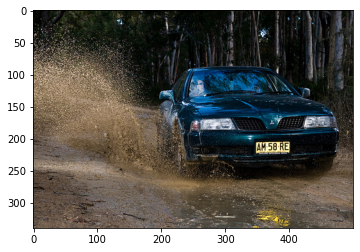

Greedy: car car drives car puddle
Beam: race car drives car puddle





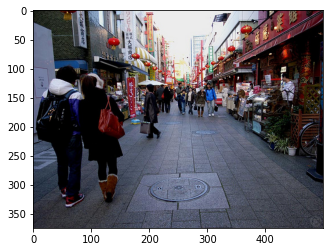

Greedy: two people walking on sidewalk street in the city
Beam: three people are walking on sidewalk street





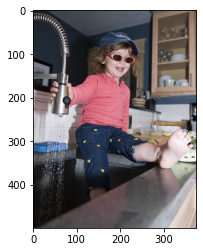

Greedy: two in red shirt and cast cigarette
Beam: man smokes cigarette





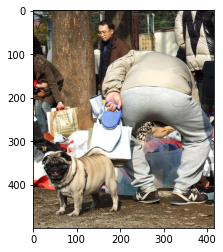

Greedy: man in red jacket is standing on the sidewalk of van
Beam: man and woman are standing on front of building





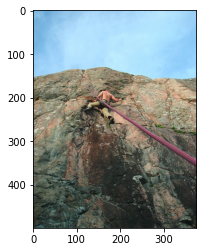

Greedy: man is climbing on rock of rock formation
Beam: man is climbing on rock of large rock formation





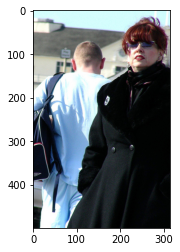

Greedy: man in woman shirt and standing print and standing cameras
Beam: man and woman pose on the street





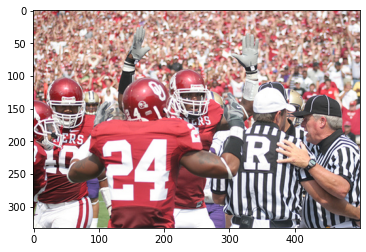

Greedy: football player quarterback to red of white uniform
Beam: group of football players players





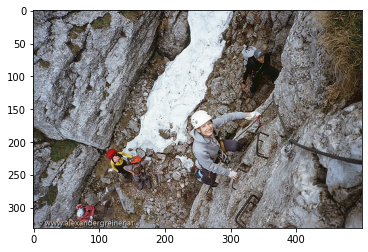

Greedy: man climbing sheer rock
Beam: person climber scales rock rock face





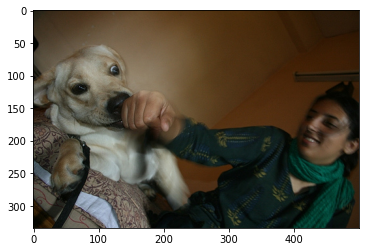

Greedy: the dog is holding on the rug
Beam: white dog is eating in the bathroom





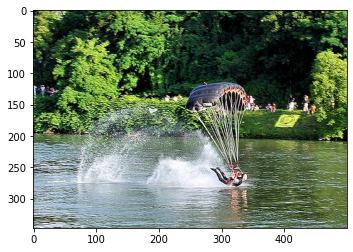

Greedy: man windsurfing off the water
Beam: man on wakeboard in the water





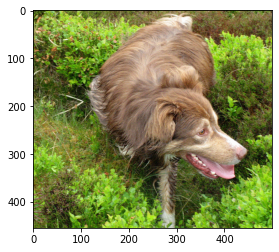

Greedy: brown dog is running through the grass
Beam: brown and white dog is running in the grass





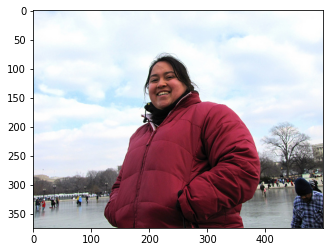

Greedy: man in red coat stands on the icy of the ocean
Beam: man standing on the icy of the ocean





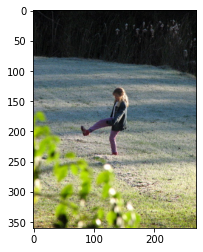

Greedy: boy girl running in the sand
Beam: little girl running in puddle





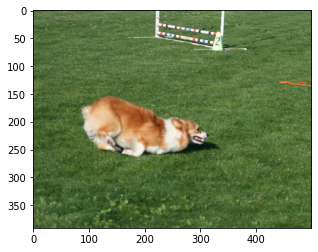

Greedy: dog is jumping over low
Beam: brown dog is jumping over hurdle





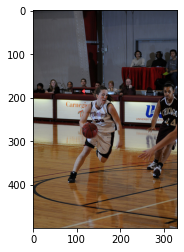

Greedy: basketball player dribbles the ball
Beam: two basketball players are playing basketball





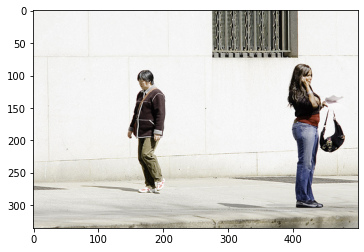

Greedy: two women are walking on sidewalk paved
Beam: group of people are walking in front of building





In [ ]:
for pic in test_image_file[20:40]: 
  encoded_image = test_features[pic].reshape((1,2048))
  x=plt.imread(images_path+pic)
  plt.imshow(x)
  plt.show()
  print("Greedy:",greedySearch(encoded_image))
  print("Beam:",beam_search_predictions(encoded_image,7))
  print("\n\n")

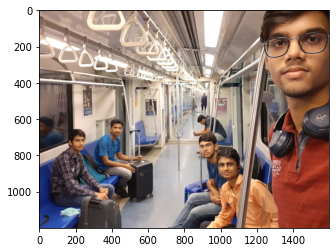

Greedy: man and woman are sitting on front of front of them
Beam: group of people are standing on front of an art gallery


In [ ]:
path = '/content/drive/MyDrive/ImageCaptioning/27493fbf-505b-44f7-82a0-0e33c1de056f.jpg'

encoded_images = encode(path).reshape((1,2048))
x=plt.imread(path)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(encoded_images))
print("Beam:",beam_search_predictions(encoded_images,7))

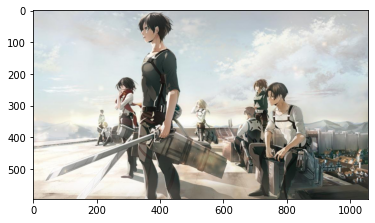

Greedy: two people are riding bicycles on the boardwalk
Beam: group of people are sitting on the pavement


In [ ]:
path = '/content/drive/MyDrive/ImageCaptioning/cropped-1920-1080-612522.jpg'

encoded_images = encode(path).reshape((1,2048))
x=plt.imread(path)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(encoded_images))
print("Beam:",beam_search_predictions(encoded_images,7))

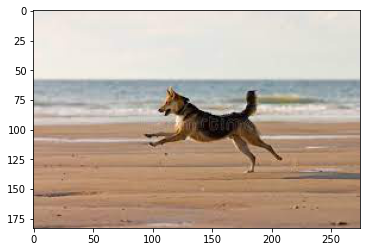

Greedy: dog is running on sandy sand
Beam: black and white dog is running on the beach


In [89]:
path = '/content/drive/MyDrive/ImageCaptioning/download.jpeg'

encoded_images = encode(path).reshape((1,2048))
x=plt.imread(path)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(encoded_images))
print("Beam:",beam_search_predictions(encoded_images,7))

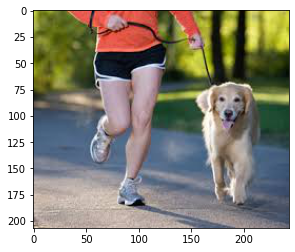

Greedy: two young is running in the grass
Beam: two young children playing in the grass


In [90]:
path = '/content/drive/MyDrive/ImageCaptioning/images.jpeg'

encoded_images = encode(path).reshape((1,2048))
x=plt.imread(path)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(encoded_images))
print("Beam:",beam_search_predictions(encoded_images,7))